In [187]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LinearRegression
from typing import List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Define the file paths for the raw data
data_raw = "../data/raw"
applications_fp = f"{data_raw}/applications.csv"
company_fp = f"{data_raw}/company_data.csv"
payments_fp = f"{data_raw}/payment_performance.csv"

In [189]:
# Load the Raw Data
apps = pd.read_csv(applications_fp, parse_dates=['application_date'])
company = pd.read_csv(company_fp, parse_dates=['incorporation_date'])
payments = pd.read_csv(payments_fp, parse_dates=['invoice_date','due_date','payment_date'])


In [190]:
print("Applications shape:", apps.shape)
print("Company data shape:", company.shape)
print("Payments shape:", payments.shape)

Applications shape: (4000, 7)
Company data shape: (1458, 8)
Payments shape: (4000, 7)


# 1. Missing Data Analysis

In [191]:
# Duplicates
print("Duplicates in apps:", apps.duplicated('application_id').sum())
print("Duplicates in company:", company.duplicated('company_id').sum())
print("Duplicates in payments (invoice+company):", payments.duplicated(['company_id','invoice_id']).sum())

Duplicates in apps: 0
Duplicates in company: 0
Duplicates in payments (invoice+company): 0


## 1.1 Applications (`apps`)

In [192]:
# Inspect missing values in the apps DataFrame 
summary = (
    pd.concat([apps.isnull().sum(), apps.isnull().mean() * 100], axis=1, keys=['missing_count', 'missing_pct'])
      .sort_values(by='missing_count', ascending=False)
)

print("=== apps DataFrame ===")
print(summary)

=== apps DataFrame ===
                  missing_count  missing_pct
risk_score                  176          4.4
company_id                    0          0.0
application_id                0          0.0
application_date              0          0.0
requested_amount              0          0.0
approved_amount               0          0.0
invoice_id                    0          0.0


- **Missingness**  
  - Only **4.4%** of records lack a `risk_score`.  
  - All other fields are complete.
- **Implications**  
  - Since `risk_score` is a primary model input, options include:  
    - **Impute** missing scores via a simple proxy (e.g. regression on approved/requested amounts)  
    - **Flag** “no score” as its own category  
    - **Drop** ~4% of rows if time-constrained
- **Decision**  
  - Impute missing risk_score values by fitting a simple linear regression on approved_amount and requested_amount. See Section 3.1.
- **Further Investigation (Time Permitting)**  
  - Run a sensitivity check: does dropping vs. imputing these rows meaningfully change your segment comparisons or model performance?

## 1.2 Payment Performance (`payments`)

In [193]:
# Inspect missing values in the payments DataFrame 
summary = (
    pd.concat([payments.isnull().sum(), payments.isnull().mean() * 100], axis=1, keys=['missing_count', 'missing_pct'])
      .sort_values(by='missing_count', ascending=False)
)

print("=== payments DataFrame ===")
print(summary)

=== payments DataFrame ===
                missing_count  missing_pct
payment_date              268          6.7
invoice_id                  0          0.0
company_id                  0          0.0
invoice_amount              0          0.0
invoice_date                0          0.0
due_date                    0          0.0
default_status              0          0.0


- **Missingness**  
  - `payment_date`: **6.7%** missing  
  - All other fields are complete.
- **Assumption**  
  - Missing `payment_date` likely indicates non-payment and would align with company defaults.  
- **Decision**  
  - Since the `payment_date` field represents **future behavior**, it would constitute a **data leakage** if used in any predictive model, and so imputation would not be logical.
  - Sanity check the assumption above for data quality purposes.

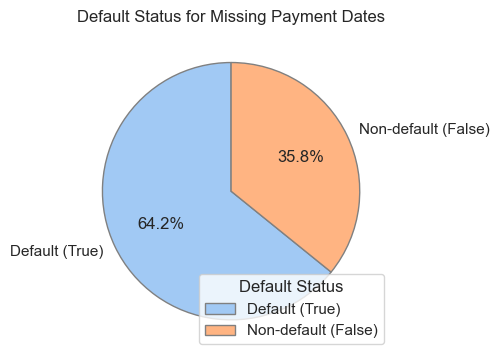

In [194]:
# Filter rows where payment_date is missing
missing_payments = payments[payments['payment_date'].isnull()]

# Count True vs False in default_status
counts = missing_payments['default_status'].value_counts()
labels = ['Default (True)', 'Non-default (False)']
sizes = [counts.get(True, 0), counts.get(False, 0)]

# Create Seaborn-style pie chart
sns.set_theme(style="white")
colors = sns.color_palette("pastel")[:2]  # soft colors for pie chart

plt.figure(figsize=(5, 5))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'gray'}
)
plt.title('Default Status for Missing Payment Dates')
plt.legend(title="Default Status")
plt.tight_layout()
plt.show()

In [195]:
# Number of rows with missing payment_date AND default_status == False
X = payments[payments['payment_date'].isnull() & (payments['default_status'] == False)].shape[0]
print("Rows with missing payment_date and default_status == False:", X)

Rows with missing payment_date and default_status == False: 96


### Note on `payment_date` Missingness and Default Status
- The `payment_date` field represents **future behavior** and would therefore constitute a **data leakage** if used in any predictive model.

It is worth noting, however, that:
- Approximately **64%** of records with a missing `payment_date` are marked as default (`default_status=True`), we would expect **100%** as if the company has not defaulted then it would have paid.
- **96 rows** have a missing `payment_date` but are **not** marked as default (`default_status=False`). 
  - This inconsistency could be due to data entry issues, delayed updates, or differences in how default status is assigned.
  - **Further investigation** into the business rules behind `default_status` and `payment_date` would be valuable in a production context.


## 1.3 Company Data (`company`)

In [196]:
# Inspect missing values in the company DataFrame 
summary = (
    pd.concat([company.isnull().sum(), company.isnull().mean() * 100], axis=1, keys=['missing_count', 'missing_pct'])
      .sort_values(by='missing_count', ascending=False)
)

print("=== company DataFrame ===")
print(summary)

=== company DataFrame ===
                        missing_count  missing_pct
net_worth                         185    12.688615
working_capital                   185    12.688615
industry_segment                  133     9.122085
incorporation_date                122     8.367627
postcode_area                     122     8.367627
external_credit_rating            121     8.299040
company_id                          0     0.000000
legal_form                          0     0.000000


- **Missingness**  
  - `working_capital` & `net_worth`: ~12.7% missing  
  - `industry_segment`, `incorporation_date`, `postcode_area`, `external_credit_rating`: ~8–9% missing  
  - `legal_form` & `company_id`: 0% missing
- **Implications**  
  - The continuous variables; `net_worth`, `working_capital` and `incorporation_date` may have a significant impact on the model and ideally a deeper dive into the data collection method and more thoughtful data imputation would be applied.
  - The categorical variables; `industry_segment`, `postcode_area`, `external_credit_rating` could use an **“Unknown”** level or **mode imputation** within similar companies.  
- **Decision**  
  - Create 'Unknown' category in categorical variables.
  - Apply 'quick and dirty' median for numerical features in the interest of time.
- **Further Investigation (Time Permitting)**  
  - Run a sensitivity check: does dropping vs. imputing these rows meaningfully change my segment comparisons or model performance.
  - Plan deeper missing-data strategies (multiple imputation, missForest) in a full analysis including a missing data audit (MCAR, MNAR, etc).

For interest's sake, visualise how mch the missing data ovrelas in the company dataframe:

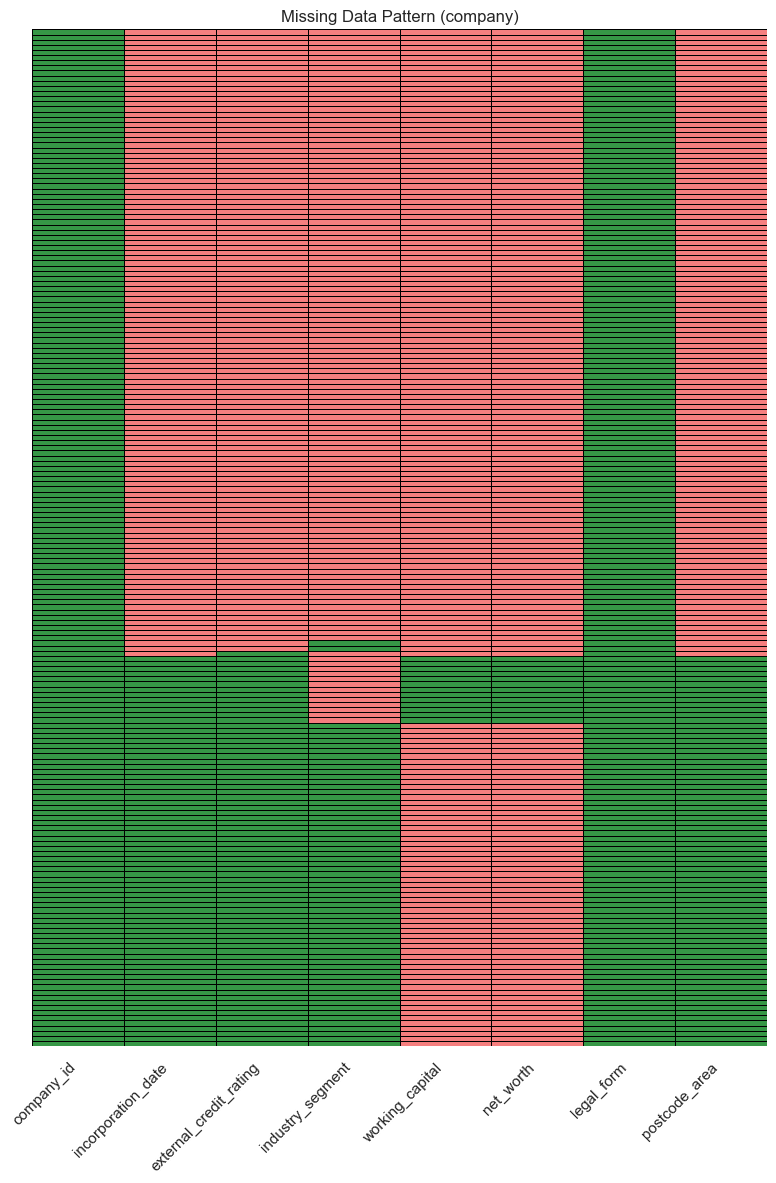

In [197]:
# Subset to rows with any missing values
company_missing = company[company.isnull().any(axis=1)]

# Create a boolean matrix for missingness
miss_mat = company_missing.isnull().astype(int)

# Plot a smaller seaborn heatmap
plt.figure(figsize=(8, 12))
sns.heatmap(
    miss_mat,
    cbar=False,
    cmap = ListedColormap(["#369746", "#f57f7f"]),
    yticklabels=False,      # hide row labels to keep it compact
    xticklabels=miss_mat.columns,
    linewidths=0.5,
    linecolor='black'
)
plt.xticks(rotation=45, ha='right')
plt.title('Missing Data Pattern (company)')
plt.tight_layout()
plt.show()

In [198]:
# replace NaN values with 'unknown' in `industry_segment`, `postcode_area` and `external_credit_rating` columns of the company DataFrame
cols_to_fill = ['industry_segment', 'postcode_area', 'external_credit_rating']
company[cols_to_fill] = company[cols_to_fill].fillna('unknown')

In [199]:
# Columns to impute with median
cols_median_fill = ['net_worth', 'working_capital', 'incorporation_date']

# Impute each with its median
for col in cols_median_fill:
    median_val = company[col].median()
    company[col] = company[col].fillna(median_val)


# 2. Data Quality Checks

In [200]:
# Number of unique companies
company['company_id'].nunique()

1458

In [201]:
# Check if all company_ids in payments and apps exist in company

company_ids_company = set(company['company_id'])
company_ids_payments = set(payments['company_id'])
company_ids_apps = set(apps['company_id'])
print("Company IDs in payments which are not in the company df:", company_ids_payments - company_ids_company)
print("Company IDs in apps which are not in the company df:", company_ids_apps - company_ids_company)

Company IDs in payments which are not in the company df: set()
Company IDs in apps which are not in the company df: set()


In [202]:
# Check if all company_ids in company appear at least once in payments or apps

# Check all company_ids in company appear at least once in payments
if company_ids_company.issubset(company_ids_payments):
    print("All company_ids in company df appear at least once in the payments df.")
else:
    missing_in_payments = company_ids_company - company_ids_payments
    print("Company IDs missing in payments:", missing_in_payments)

# Check all company_ids in company appear at least once in apps
if company_ids_company.issubset(company_ids_apps):
    print("All company_ids in company df appear at least once in the apps df.")
else:
    missing_in_apps = company_ids_company - company_ids_apps
    print("Company IDs missing in apps:", missing_in_apps)

All company_ids in company df appear at least once in the payments df.
All company_ids in company df appear at least once in the apps df.


Clean the company IDs so that they are more readable for the purpose of this task:

In [203]:
def remap_ids(df_list: List[pd.DataFrame], id_col: str) -> Tuple[List[pd.DataFrame], pd.DataFrame]:
    # Gather all unique values from the first DataFrame (assumed to contain the master list)
    old_ids = df_list[0][id_col].unique()
    
    # Create a mapping from old to new friendly IDs
    id_mapping = {old_id: new_id for new_id, old_id in enumerate(old_ids, start=1)}
    
    # Apply the mapping to each DataFrame
    for df in df_list:
        df[id_col] = df[id_col].map(id_mapping)
    
    # Return mapping DataFrame for reference
    mapping_df = pd.DataFrame(list(id_mapping.items()), columns=[f'old_{id_col}', f'friendly_{id_col}'])
    return df_list, mapping_df

# Remap company_id
[company, apps, payments], company_map = remap_ids([company, apps, payments], 'company_id')

# Remap application_id in apps
[apps], application_map = remap_ids([apps], 'application_id')

# Remap invoice_id in both apps and payments
[apps, payments], invoice_map = remap_ids([apps, payments], 'invoice_id')


In [204]:
# Lookup
result = company_map.loc[company_map['old_company_id'] == '1,718,328,119,872,710,000', 'friendly_company_id']

# Print result
print(result.values)

[1125]


In [205]:
# company, apps, payments, id_map = remap_company_ids(company, apps, payments)
print('Company ID Map Snippet:')
print(company_map.head())  # old-to-new ID mapping

print('Application ID Map Snippet:')
print(application_map.head())

print('Invoice ID Map Snippet:')
print(invoice_map.head())

Company ID Map Snippet:
               old_company_id  friendly_company_id
0   3,935,285,571,697,710,000                    1
1   7,159,193,073,642,430,000                    2
2  -4,640,137,908,825,900,000                    3
3  -7,071,318,460,949,380,000                    4
4  -6,022,528,274,177,040,000                    5
Application ID Map Snippet:
                     old_application_id  friendly_application_id
0  5f73bf55-bb4b-47e7-bfac-4cecdcc1b4f4                        1
1  3e59a50f-ffe6-456c-a383-6204509cc499                        2
2  301202af-5bb2-4d29-b7c4-1a9c039fcab5                        3
3  fcbf5c4e-e35e-4d4e-a185-24ca209cd878                        4
4  661478b4-0682-4f19-9213-54b198e0a499                        5
Invoice ID Map Snippet:
                         old_invoice_id  friendly_invoice_id
0  0a5dbb39-75df-42fb-a41a-7c626c83a7ca                    1
1  f6147da3-5b9b-4769-adcc-adfef51c6ac3                    2
2  1762f635-38a4-44e2-be08-c331f3c559aa      

Sanity check that the same number of applications per company in the apps df appear in the payments df:

In [206]:
# Get top 10 most frequent company_ids in apps
top_companies = apps['company_id'].value_counts().head(10)

# Build summary DataFrame
summary_df = pd.DataFrame({
    'apps_count': top_companies,
    'payments_count': top_companies.index.map(payments['company_id'].value_counts()).fillna(0).astype(int)
})

# Reset index for nicer display
summary_df.index.name = 'company_id'
summary_df = summary_df.reset_index()
summary_df

,company_id,apps_count,payments_count
0,860,202,202
1,845,87,87
2,809,86,86
3,972,52,52
4,903,40,40
5,1312,37,37
6,647,34,34
7,1074,33,33
8,654,32,32
9,519,31,31


Note that many more data quality checks could be applied here, time permitting.

# 3. Data Cleaning & Feature Engineering

## 3.1 Applications (`apps`)

In [207]:
# View the data types in the apps df
apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   application_id    4000 non-null   int64         
 1   company_id        4000 non-null   int64         
 2   application_date  4000 non-null   datetime64[ns]
 3   requested_amount  4000 non-null   object        
 4   approved_amount   4000 non-null   object        
 5   risk_score        3824 non-null   float64       
 6   invoice_id        4000 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 218.9+ KB


In [ ]:
# Create new date/time-related features
apps['app_date_only'] = apps['application_date'].dt.date
apps['app_day_of_week'] = apps['application_date'].dt.day_name()
apps['app_time'] = apps['application_date'].dt.time

In [209]:
# clean the messy requested_amount feature
apps['requested_amount_clean'] = apps['requested_amount'].astype(str) \
    .str.replace(',', '', regex=False)
apps['requested_amount_clean'] = pd.to_numeric(
    apps['requested_amount_clean'], errors='coerce'
)

In [210]:
# Log-transform requested amounts (add 1 to avoid log(0))
apps['log_requested_amount'] = np.log1p(apps['requested_amount_clean'])

In [211]:
# View the approved_amount categories
apps['approved_amount'].unique()

array(['10000-50000', '100000-500000', 'over 500000', '50000-100000',
       '1000-5000', '5000-10000', 'up to 1000'], dtype=object)

In [212]:
# Categorize the approved_amount feature
bands = [
    'up to 1000',
    '1000-5000',
    '5000-10000',
    '10000-50000',
    '50000-100000',
    '100000-500000',
    'over 500000'
]

# Convert to an ordered CategoricalDtype
approved_cat = pd.CategoricalDtype(categories=bands, ordered=True)
apps['approved_amount_ord'] = apps['approved_amount'].astype(approved_cat)

Impute missing risk_score values with a simple linear regression model using the approved maximum amount and the requested amount.

In [213]:
# Function to convert approved_amount band into a max numeric value for risk_score imputation
def extract_max_amount(value: str) -> float:
    if pd.isna(value):
        return np.nan
    if value == 'over 500000':
        return 750_000  # An arbitrary upper cap
    elif value == 'up to 1000':
        return 1000
    else:
        try:
            # Extract the upper number from ranges like '1000-5000'
            return int(value.split('-')[1])
        except:  
            return np.nan

# Apply the function to create a numeric column
apps['approved_amount_max'] = apps['approved_amount'].apply(extract_max_amount).astype(float)

In [214]:
apps.head()

,application_id,company_id,application_date,requested_amount,approved_amount,risk_score,invoice_id,app_date_only,app_day_of_week,app_time,requested_amount_clean,log_requested_amount,approved_amount_ord,approved_amount_max
0,1,63,2022-02-01 09:07:00,78,10000-50000,NaN,1,2022-02-01,Tuesday,09:07:00,78,4.369448,10000-50000,50000.0
1,2,957,2022-02-01 09:13:00,"5,352",100000-500000,1.16,2,2022-02-01,Tuesday,09:13:00,5352,8.585412,100000-500000,500000.0
2,3,195,2022-02-01 12:33:00,"1,650",over 500000,2.26,3,2022-02-01,Tuesday,12:33:00,1650,7.409136,over 500000,750000.0
3,4,337,2022-02-01 12:40:00,744,over 500000,3.26,4,2022-02-01,Tuesday,12:40:00,744,6.613384,over 500000,750000.0
4,5,204,2022-02-01 12:58:00,617,over 500000,2.92,5,2022-02-01,Tuesday,12:58:00,617,6.426488,over 500000,750000.0


In [215]:
# Split into train (where risk_score exists) and predict (where it’s missing)
train = apps[apps['risk_score'].notnull()]
pred= apps[apps['risk_score'].isnull()]

# Features and target
X_train = train[['requested_amount_clean', 'approved_amount_max']]
y_train = train['risk_score']
X_pred = pred[['requested_amount_clean', 'approved_amount_max']]

# Fit the regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predict missing values
imputed_values = model.predict(X_pred)

# Fill back into your DataFrame
apps.loc[apps['risk_score'].isnull(), 'risk_score'] = imputed_values

# Inspect how many you filled and basic stats
n_imputed = imputed_values.shape[0]
print(f"Imputed {n_imputed} risk_score values.")
print("Imputed risk_score range:",
      imputed_values.min().round(1), "–", imputed_values.max().round(1))

Imputed 176 risk_score values.
Imputed risk_score range: 3.4 – 5.9


In [216]:
apps.columns

Index(['application_id', 'company_id', 'application_date', 'requested_amount',
       'approved_amount', 'risk_score', 'invoice_id', 'app_date_only',
       'app_day_of_week', 'app_time', 'requested_amount_clean',
       'log_requested_amount', 'approved_amount_ord', 'approved_amount_max'],
      dtype='object')

In [217]:
# Drop unneccasary columns
app_cols_to_drop = ['application_date', 'requested_amount', 'approved_amount', 'approved_amount_max']
apps.drop(columns=app_cols_to_drop, inplace=True)
apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   application_id          4000 non-null   int64   
 1   company_id              4000 non-null   int64   
 2   risk_score              4000 non-null   float64 
 3   invoice_id              4000 non-null   int64   
 4   app_date_only           4000 non-null   object  
 5   app_day_of_week         4000 non-null   object  
 6   app_time                4000 non-null   object  
 7   requested_amount_clean  4000 non-null   int64   
 8   log_requested_amount    4000 non-null   float64 
 9   approved_amount_ord     4000 non-null   category
dtypes: category(1), float64(2), int64(4), object(3)
memory usage: 285.6+ KB


In [218]:
apps.head()

,application_id,company_id,risk_score,invoice_id,app_date_only,app_day_of_week,app_time,requested_amount_clean,log_requested_amount,approved_amount_ord
0,1,63,5.701493,1,2022-02-01,Tuesday,09:07:00,78,4.369448,10000-50000
1,2,957,1.160000,2,2022-02-01,Tuesday,09:13:00,5352,8.585412,100000-500000
2,3,195,2.260000,3,2022-02-01,Tuesday,12:33:00,1650,7.409136,over 500000
3,4,337,3.260000,4,2022-02-01,Tuesday,12:40:00,744,6.613384,over 500000
4,5,204,2.920000,5,2022-02-01,Tuesday,12:58:00,617,6.426488,over 500000


## 3.2 Payment Performance (`payments`)

In [219]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   company_id      4000 non-null   int64         
 1   invoice_id      4000 non-null   int64         
 2   invoice_amount  4000 non-null   object        
 3   invoice_date    4000 non-null   datetime64[ns]
 4   due_date        4000 non-null   datetime64[ns]
 5   payment_date    3732 non-null   datetime64[ns]
 6   default_status  4000 non-null   bool          
dtypes: bool(1), datetime64[ns](3), int64(2), object(1)
memory usage: 191.5+ KB


In [220]:
payments.columns

Index(['company_id', 'invoice_id', 'invoice_amount', 'invoice_date',
       'due_date', 'payment_date', 'default_status'],
      dtype='object')

In [221]:
# clean the messy invoice amount feature
payments['invoice_amount_clean'] = payments['invoice_amount'].astype(str) \
    .str.replace(',', '', regex=False)

payments['invoice_amount_clean'] = pd.to_numeric(
    payments['invoice_amount_clean'], errors='coerce'
)

In [222]:
# Create the feature days from invoice issuance to due date 'days_until_due'
payments['days_until_due'] = (
    payments['due_date'] - payments['invoice_date']
).dt.days

In [223]:
# Create feature days between due date and actual payment
# (positive if late, negative if early)
payments['days_past_due'] = (
    payments['payment_date'] - payments['due_date']
).dt.days

In [ ]:
# Create a flag if paid on time or early
#    True = payment_date <= due_date (on-time or early)
#    False = payment_date > due_date  (late)
payments['paid_on_time'] = (
    payments['payment_date'] <= payments['due_date']
)

In [225]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   company_id            4000 non-null   int64         
 1   invoice_id            4000 non-null   int64         
 2   invoice_amount        4000 non-null   object        
 3   invoice_date          4000 non-null   datetime64[ns]
 4   due_date              4000 non-null   datetime64[ns]
 5   payment_date          3732 non-null   datetime64[ns]
 6   default_status        4000 non-null   bool          
 7   invoice_amount_clean  4000 non-null   int64         
 8   days_until_due        4000 non-null   int64         
 9   days_past_due         3732 non-null   float64       
 10  paid_on_time          4000 non-null   bool          
dtypes: bool(2), datetime64[ns](3), float64(1), int64(4), object(1)
memory usage: 289.2+ KB


We can't use payment date, days_past_due or paid_on_time in a predictive model, as this would be a form of data leakage.

In [226]:
# Drop unneccasary columns
paym_cols_to_drop = ['invoice_amount']
payments.drop(columns=paym_cols_to_drop, inplace=True)

## 3.3 Company Data (`company`)

In [227]:
company.tail()

,company_id,incorporation_date,external_credit_rating,industry_segment,working_capital,net_worth,legal_form,postcode_area
1453,1454,2022-05-05,Moderate Risk,AccommFood,114254.0,194692.0,Private limited with Share Capital,EH2
1454,1455,2022-05-18,Moderate Risk,WholesaleRetail,114254.0,194692.0,Private limited with Share Capital,PL4
1455,1456,2022-05-28,Moderate Risk,ArtsRecr,114254.0,194692.0,Private limited with Share Capital,N1
1456,1457,2022-06-14,Moderate Risk,AccommFood,114254.0,194692.0,Private limited with Share Capital,DA12
1457,1458,2022-09-22,Moderate Risk,Construct,114254.0,194692.0,Private limited with Share Capital,DA1


In [228]:
company['external_credit_rating'].unique()

array(['unknown', 'Royal Charter Company', 'Low Risk', 'Moderate Risk',
       'Very Low Risk', 'High Risk', 'Analysed - Non balancing',
       'Non trading'], dtype=object)

Decision to split `external_credit_rating` into a categorical column `type_of_external_credit_rating` which takes on values:
1. 'External credit risk' (if it has value  'Low Risk', 'Moderate Risk', 'Very Low Risk', 'High Risk'  in the external_credit_rating column)
2. 'Analysed non balancing'
3. 'Non trading'
4. 'Royal charter company'
5.  'unknown'

And an ordinal column `external_credit_rating_label` which captures actual ordinal risk:
1. 'Very Low Risk'
2. 'Low Risk'
3. 'Moderate Risk'
4. 'High Risk'

This way, we can obtain value from the **ordinal** credit risk ratings without forcing meaning in the ranking of the **'Analysed non balancing'**, **'Non trading'** or **'Royal charter company'** ratings.

In [229]:
# Define risk levels
ordinal_ratings = ['Very Low Risk', 'Low Risk', 'Moderate Risk', 'High Risk']

def get_type_of_external_credit_rating(val: Optional[str]) -> Optional[str]:
    if pd.isna(val):
        return np.nan
    elif val in ordinal_ratings:
        return 'External credit risk'
    else:
        return val
        
def get_external_credit_rating_label(val: Optional[str]) -> Optional[str]:
    return val if val in ordinal_ratings else np.nan

# Apply to DataFrame
company['type_of_external_credit_rating'] = company['external_credit_rating'].apply(get_type_of_external_credit_rating)
company['external_credit_rating_label'] = company['external_credit_rating'].apply(get_external_credit_rating_label)

# Convert rating label to ordered category
company['external_credit_rating_label'] = pd.Categorical(
    company['external_credit_rating_label'],
    categories=['Very Low Risk', 'Low Risk', 'Moderate Risk', 'High Risk'],
    ordered=True
)

# Convert type_of_external_credit_rating to a categorical feature
company['type_of_external_credit_rating'] = pd.Categorical(company['type_of_external_credit_rating'])

# Drop the original external_credit_rating column
# Drop unneccasary columns
company_cols_to_drop = ['external_credit_rating']
company.drop(columns=company_cols_to_drop, inplace=True)
company.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   company_id                      1458 non-null   int64         
 1   incorporation_date              1458 non-null   datetime64[ns]
 2   industry_segment                1458 non-null   object        
 3   working_capital                 1458 non-null   float64       
 4   net_worth                       1458 non-null   float64       
 5   legal_form                      1458 non-null   object        
 6   postcode_area                   1458 non-null   object        
 7   type_of_external_credit_rating  1458 non-null   category      
 8   external_credit_rating_label    1334 non-null   category      
dtypes: category(2), datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 83.1+ KB


In [43]:
# Convert industry_segment to a categorical feature
company['industry_segment'] = pd.Categorical(company['industry_segment'])

# Convert legal_form to a categorical feature
company['legal_form'] = pd.Categorical(company['legal_form'])

# Convert postcode_area to a categorical feature
company['postcode_area'] = pd.Categorical(company['postcode_area'])


In [44]:
# Calculate age in years (rounded down)
company['company_age'] = (pd.to_datetime("today") - company['incorporation_date']).dt.days // 365

In [45]:
# Create a Boolean flag for the Construction segment
company['is_construction'] = company['industry_segment'] == 'Construct'

In [46]:
# Add log-transformed columns (adding 1 to avoid log(0))
company["log_working_capital"] = np.log1p(company["working_capital"])
company["log_net_worth"] = np.log1p(company["net_worth"])

In [47]:
# Create a segment group column for future comparisons
company['sector_group'] = company['is_construction'].map({True: "Construction", False: "Other Sectors"})

# 4. Save new dataframes

Save each processed df under data/processed as a pkl file, these are Python-specific but extremely fast.

In [48]:
# Define output path
output_path = "../data/processed/"

# Save each DataFrame as a CSV file
apps.to_pickle(f"{output_path}applications.pkl")
company.to_pickle(f"{output_path}company.pkl")
payments.to_pickle(f"{output_path}payment.pkl")

Create one df with all information for easy model creation and store it under data/processed as well.

In [49]:
# Copy the payments DataFrame (which has default_status)
df_merged = payments.copy(deep=True)

# Merge company data by company_id
df_merged = df_merged.merge(
    company,
    on='company_id',
    how='left',
    suffixes=(None, '_company')
)

# Merge application data by invoice_id, dropping redundant company_id from apps
apps_subset = apps.drop(columns=['company_id'])
df_merged = df_merged.merge(
    apps_subset,
    on='invoice_id',
    how='left',
    suffixes=(None, '_app')
)

# Inspect the merged schema
print(df_merged.columns.tolist())
print(df_merged[['default_status', 'company_id', 'invoice_id']].head())

# Save this combined dataset
df_merged.to_pickle(f"{output_path}merged.pkl")

['company_id', 'invoice_id', 'invoice_date', 'due_date', 'payment_date', 'default_status', 'invoice_amount_clean', 'days_until_due', 'days_past_due', 'paid_on_time', 'incorporation_date', 'industry_segment', 'working_capital', 'net_worth', 'legal_form', 'postcode_area', 'type_of_external_credit_rating', 'external_credit_rating_label', 'company_age', 'is_construction', 'log_working_capital', 'log_net_worth', 'sector_group', 'application_id', 'risk_score', 'app_date_only', 'app_day_of_week', 'app_time', 'requested_amount_clean', 'log_requested_amount', 'approved_amount_ord']
   default_status  company_id  invoice_id
0           False         337          31
1           False        1006          11
2           False         490          33
3           False          63           1
4           False        1175          25


Future Ideas:
Location for postal codes
A company's individual history - i.e. if they have not defaulted in the last few applications are they a safer risk or if they have recently defaulted are they riskier etc.